In [1]:

import torch
from myutil import *
import time
from PIL import Image
from torchvision.transforms import functional as TVF
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

c:\Users\Bliss\Desktop\UofT\MIE1517\Project\project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
frame = cv2.imread("captured_frame.jpg")
frame.shape

(480, 640, 3)

In [3]:
class_to_idx = {"bottle":0, 
                "fork":1,
                "knife":2,
                "spoon":3
                }
idx_to_class = {i:c for c, i in class_to_idx.items()}

_________________

640 480
640 480


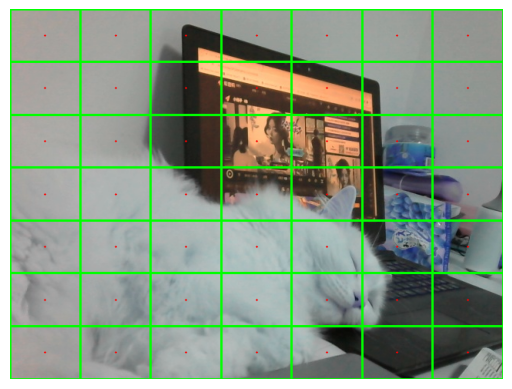

In [4]:
grid_list = GenerateGrid()
h=frame.shape[0]
w=frame.shape[1]
center = torch.cat((grid_list, grid_list), dim=-1)
grid_cell = center.clone()
grid_cell[:, :, [0, 1]] -= 1. / 2.
grid_cell[:, :, [2, 3]] += 1. / 2.
center = coord_trans(center, w,h)
grid_cell = coord_trans(grid_cell,w,h)
data_visualizer(frame, idx_to_class, center.reshape(-1, 4), grid_cell.reshape(-1, 4))# center and grid_cell need to reshape to 49,4 

In [5]:
anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]]) # hyperparameter
anc_list = GenerateAnchor(anchor_list, grid_list)


********************************************************************************
All nine anchors should be exactly centered:
tensor([[3.0000, 3.0000, 4.0000, 4.0000],
        [2.5000, 2.5000, 4.5000, 4.5000],
        [2.0000, 2.0000, 5.0000, 5.0000],
        [1.5000, 1.5000, 5.5000, 5.5000],
        [1.0000, 1.0000, 6.0000, 6.0000],
        [2.5000, 2.0000, 4.5000, 5.0000],
        [2.0000, 2.5000, 5.0000, 4.5000],
        [2.0000, 1.0000, 5.0000, 6.0000],
        [1.0000, 2.0000, 6.0000, 5.0000]])
640 480


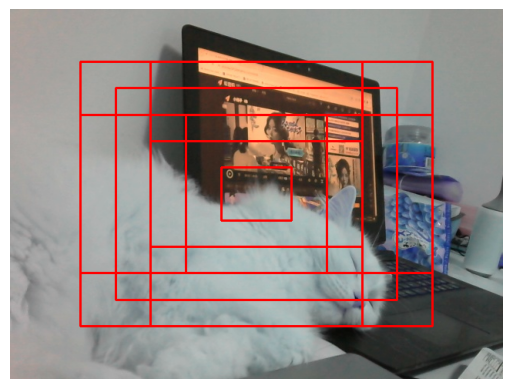

In [6]:
print('*'*80)
print('All nine anchors should be exactly centered:')
anc_list = GenerateAnchor(anchor_list, grid_list[3:4,3:4])
print(anc_list.reshape(-1,4))
data_visualizer(frame, idx_to_class, coord_trans(anc_list.reshape(-1,4),w,h))# center and grid_cell need to reshape to 49,4 


********************************************************************************
All nine anchors should be exactly centered:
tensor([[0., 0., 1., 1.],
        [1., 0., 2., 1.],
        [2., 0., 3., 1.],
        ...,
        [2., 5., 7., 8.],
        [3., 5., 8., 8.],
        [4., 5., 9., 8.]])
640 480


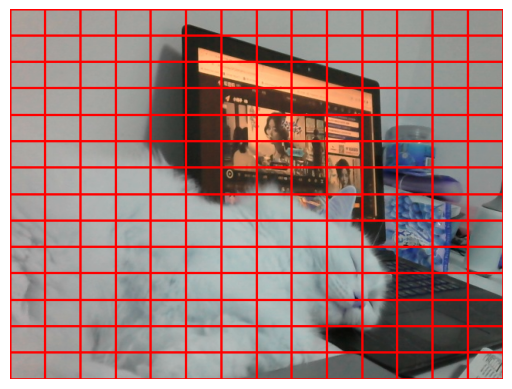

In [7]:
print('*'*80)
print('All nine anchors should be exactly centered:')
anc_list = GenerateAnchor(anchor_list, grid_list)
print(anc_list.reshape(-1,4))
data_visualizer(frame, idx_to_class, coord_trans(anc_list.reshape(-1,4),w,h))# center and grid_cell need to reshape to 49,4 

--- testing Proposal module

In [8]:

preprocess = transforms.Compose([
                transforms.ToPILImage(),  # Convert tensor to PIL Image
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])
transformed_frame  = preprocess (frame)

In [9]:
vgg16 = models.vgg16(pretrained=True)
        # output of conv5_3 of vgg16 is N x 512 x 14 x 14
vgg16 = nn.Sequential(*list(vgg16.features)[:30]) # layers up to and including the activation of conv5_3

c:\Users\Bliss\Desktop\UofT\MIE1517\Project\project\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bliss\Desktop\UofT\MIE1517\Project\project\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
vgg16(transformed_frame.unsqueeze(0)).shape

torch.Size([1, 512, 14, 14])

--end testing

In [11]:
class RPN(nn.Module):
    def __init__(self):
        super().__init__()

        # READ ONLY
        self.anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]])
        #self.feat_extractor = FeatureExtractor()
        self.feat_extractor = VGG16FeatureExtractor()
        self.prop_module = ProposalModule(1280, num_anchors=self.anchor_list.shape[0]) #input size for mobile net 1280

    def load_weights(self, weights_file):
        # Load trained weights from the file
        trained_weights = torch.load(weights_file)

        # Extract the model's state dictionary from the loaded state dictionary
        model_state_dict = trained_weights['model_state_dict']

        # Print keys for the extracted model's state_dict and the model's state_dict
        # print("Keys in extracted model's state_dict:")
        # print(model_state_dict.keys())
        # print("\nKeys in model's state_dict:")
        # print(self.state_dict().keys())

        # Check if the extracted model's state_dict matches the model's architecture
        if set(model_state_dict.keys()) != set(self.state_dict().keys()):
            print("\nError: Model architecture mismatch. Loaded weights don't match model's architecture.")
            return

        # Assign the trained weights to the model parameters
        self.load_state_dict(model_state_dict)


    def inference(self, images, thresh=0.5, nms_thresh=0.7, mode='RPN'):

        assert mode in ('RPN', 'FasterRCNN'), 'invalid inference mode!'

        features, final_conf_probs, final_proposals = None, None, None

        # Here we predict the RPN proposal coordinates `final_proposals` and        #
        # confidence scores `final_conf_probs`.                                     #
        # The overall steps are similar to the forward pass but now you do not need  #
        # to decide the activated nor negative anchors.                              #
        # Threshold the conf_scores based on the threshold value `thresh`.     #
        # Then, apply NMS to the filtered proposals given the threshold `nms_thresh`.#


        final_conf_probs, final_proposals = [],[]
        # i) Image feature extraction
        features = self.feat_extractor(images)

        # ii) Grid and anchor generation
        grid = GenerateGrid()
        # anchors = GenerateAnchor(self.anchor_list.cuda(), grid)
        anchors = GenerateAnchor(self.anchor_list.to(grid.device, grid.dtype), grid)

        # iii) Compute conf_scores, proposals, class_prob through the prediction network
        conf_scores, offsets = self.prop_module(features)
        #offsets: (B, A, 4, H', W')
        #conf_scores: (B, A, 2, H', W')
        A,_,H,W = conf_scores.shape
        # Need to dig out from here 2024 03 11

        offsets = offsets.permute((0,2,3,1))
        # offsets=offsets.to(grid.device)
        # print(anchors.device)
        # print(offsets.device)

        proposals = GenerateProposal(anchors, offsets) #proposals:A,H,W,4
        # proposals is torch.Size([1, 13, 7, 7, 4])
        # transform
        # print(conf_scores.shape) #9 2 7 7 
        # print(proposals.shape) #9 7 7 4 

        conf_scores = torch.sigmoid(conf_scores[:,0,:,:]) # only look at the 1st confidence score which represent obj_conf
        conf_scores = conf_scores.permute((1,2,0)).reshape(-1)
        proposals = proposals.permute((1,2,0,3)).reshape(-1,4)
        # print(proposals,conf_scores)
        # Filter proposals by confidence scores
        mask1 = conf_scores > thresh
        sub_conf_scores = conf_scores[mask1]
        sub_proposals = proposals[mask1]


        # Apply NMS
        mask2 = nms(sub_proposals, sub_conf_scores, iou_threshold=nms_thresh)

        # Append filtered proposals and confidence scores
        final_proposals.append(sub_proposals[mask2,:])
        final_conf_probs.append(sub_conf_scores[mask2].unsqueeze(1))


        if mode == 'RPN':
            features = [torch.ones_like(i) for i in final_conf_probs] # dummy class
        
        return final_proposals, final_conf_probs, features

In [12]:
import torchvision
class TwoStageDetector(nn.Module):
  def __init__(self, in_dim=1280, hidden_dim=256, num_classes=4, \
               roi_output_w=2, roi_output_h=2, drop_ratio=0.3):
    super().__init__()

    assert(num_classes != 0)
    self.num_classes = num_classes # number of classes (excluding the background)
    self.roi_output_w, self.roi_output_h = roi_output_w, roi_output_h
    self.rpn = RPN() # RPM model
    self.classificationLayer = nn.Sequential( # Define the classifier
          nn.Linear(in_dim,hidden_dim),
          nn.Dropout(drop_ratio),
          nn.ReLU(),
          nn.Linear(hidden_dim,self.num_classes)
        )
    self.MeanPool = nn.AvgPool2d((7,7))#added
  def load_weights(self, weights_file):
      # Load trained weights from the file
      trained_weights = torch.load(weights_file)

      # Extract the model's state dictionary from the loaded state dictionary
      model_state_dict = trained_weights['model_state_dict']

      # Print keys for the extracted model's state_dict and the model's state_dict
      # print("Keys in extracted model's state_dict:")
      # print(model_state_dict.keys())
      # print("\nKeys in model's state_dict:")
      # print(self.state_dict().keys())

      # Check if the extracted model's state_dict matches the model's architecture
      if set(model_state_dict.keys()) != set(self.state_dict().keys()):
          print("\nError: Model architecture mismatch. Loaded weights don't match model's architecture.")
          return

      # Assign the trained weights to the model parameters
      self.load_state_dict(model_state_dict)  
  def inference(self, images, thresh=0.5, nms_thresh=0.7):

    final_proposals, final_conf_probs, final_class = None, None, None

    final_class=[]
    final_proposals, final_conf_probs, features = self.rpn.inference(images, thresh,
                                                                     nms_thresh,mode='FasterRCNN')

    aligned_features = torchvision.ops.roi_align(features, final_proposals,
                                                 (self.roi_output_w, self.roi_output_h))
    pooled_features = torch.mean(aligned_features,(2,3))
    cls_scores = self.classificationLayer(pooled_features)
    cls = torch.max(cls_scores,1)[1].to(torch.int64).unsqueeze(1)
    # slice cls into groups
    count = 0
    for i in range(len(final_proposals)):
      tmp_len=len(final_proposals[i])
      final_class.append(cls[count:count+tmp_len])
      count += tmp_len

    return final_proposals, final_conf_probs, final_class

In [13]:

def load_rpnmodel():
    # Instantiate your Faster R-CNN model and load trained weights
    model = RPN()  # Example: Replace RPN with your actual model class
    model.load_weights("detector_checkpointRPN20240319.pth")
    # Load trained weights if necessary
    return model

# Detect objects in a frame
def detect_objects(frame, model,w,h,thr,nms_thr):
    # Perform object detection using your model
    # Example: detections = model.inference(frame)
    # valid_box = sum([1 if j != -1 else 0 for j in boxes[idx][:, 0]])

    final_proposals, final_conf_scores, final_class = model.inference(frame,thresh=thr, nms_thresh=nms_thr)
    # print(final_proposals,final_conf_scores, final_class)
    final_proposals = torch.cat(final_proposals)
    final_class = torch.cat(final_class)
    final_conf_scores = torch.cat(final_conf_scores)
    # print(final_conf_scores,final_class,final_proposals)
    final_all = torch.cat((final_proposals, final_class, final_conf_scores),dim=1).cpu()
    resized_proposals = coord_trans(final_all, h, w)
    return frame,resized_proposals



In [14]:
def load_model():
    # Instantiate your Faster R-CNN model and load trained weights
    model = TwoStageDetector()  # Example: Replace RPN with your actual model class
    model.load_weights("detector_checkpoint20240319.pth")
    # Load trained weights if necessary
    return model

480 640


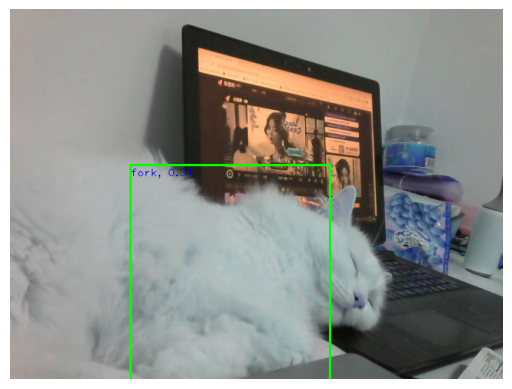

In [17]:
h=frame.shape[0] # height of the image
w=frame.shape[1] # width of the image
preprocess = transforms.Compose([
                transforms.ToPILImage(),  # Convert tensor to PIL Image
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])
model = load_model().eval()
transformed_frame = preprocess (frame)

detframe,box = detect_objects(transformed_frame, model,w,h,thr=0.3,nms_thr=0.7) # change the thr and nms_thr for better results
# data_visualizer(transformed_frame.permute(1,2,0),idx_to_class)
# print(box.int())
# # Visualize bounding boxes on the input frame
data_visualizer(frame, idx_to_class, bbox=None, pred=box)